##### Autores: Carlos Eduardo de Carvalho, Francisca Soares de Araújo, Julia Caram Sfair
#### Estes scripts foram desenvolvidos no contexto do projeto intitulado: 
#### Efeito das Mudanças Climáticas na Distribuição de Plantas com Diferentes Estratégias de Uso de Água



In [1]:
from glob import glob
import rasterio
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.font_manager import FontProperties
import geopandas as gpd
import rasterstats as rs
import seaborn as sns
import os
#import warnings
#warnings.filterwarnings('ignore')

%matplotlib inline
%load_ext rpy2.ipython
sns.set(font_scale=1.5)
plt.style.use('fivethirtyeight')
font = FontProperties()
font.set_family('serif')
font.set_name('Times New Roman')
font.set_style('italic')

/home/eduardo/.local/lib/python3.6/site-packages/pandas/compat/_optional.py:106: UserWarning: Pandas requires version '1.2.1' or newer of 'bottleneck' (version '1.2.0' currently installed).
  warnings.warn(msg, UserWarning)


In [2]:
%%R
library(dismo)
library(raster)
library(maptools)
library(sf)
library(corrplot)
library(ggfortify)

R[write to console]: Carregando pacotes exigidos: raster

R[write to console]: Carregando pacotes exigidos: sp

R[write to console]: Checking rgeos availability: TRUE

R[write to console]: Linking to GEOS 3.8.0, GDAL 2.4.2, PROJ 5.2.0

R[write to console]: WARNING: different compile-time and runtime versions for GEOS found:

R[write to console]: Linked against: 3.8.0-CAPI-1.13.1  compiled against: 3.7.1-CAPI-1.11.1

R[write to console]: It is probably a good idea to reinstall sf, and maybe rgeos and rgdal too

R[write to console]: corrplot 0.84 loaded

R[write to console]: Carregando pacotes exigidos: ggplot2



# Pré-Processa os Dados Brutos de Ocorrência de Espécies

In [3]:
for caminho in glob('/home/eduardo/projetos/conservacao_de_plantas_mudancas_climaticas/data/species_ocurrence/raw/*/*'):
    fonte = caminho.split('/')[-2]
    especie = (caminho.split('/')[-1].replace('.csv',''))
    caminho_final='/home/eduardo/projetos/conservacao_de_plantas_mudancas_climaticas/data/species_ocurrence/processed/'
    
    if fonte == 'gbif':
        ocorrencias1 = pd.read_csv(caminho,sep='\t')
        ocorrencias1 = pd.concat([ocorrencias1['scientificName'], ocorrencias1['decimalLatitude'],
                                 ocorrencias1['decimalLongitude'],ocorrencias1['locality'], ocorrencias1['year']],axis=1)
        
        ocorrencias1.columns=['specie','latitude','longitude','locality','year']
        
        ocorrencias1=ocorrencias1[pd.notnull(ocorrencias1['latitude'])]
        ocorrencias1=ocorrencias1[pd.notnull(ocorrencias1['longitude'])]
        ocorrencias1.latitude.astype(float)
        ocorrencias1.longitude.astype(float)
        ocorrencias1=ocorrencias1[ocorrencias1['latitude']!=0]
        ocorrencias1=ocorrencias1[ocorrencias1['longitude']!=0]
        ocorrencias1=ocorrencias1[ocorrencias1['year']!=0]
        ocorrencias1=ocorrencias1[pd.notnull(ocorrencias1['year'])]    
        ocorrencias1=ocorrencias1.drop_duplicates()
        ocorrencias1.year.astype(float)
        ocorrencias1=ocorrencias1[ocorrencias1.year > 1980.]
        ocorrencias1.to_csv('{0}{1}_{2}_1980_2020.csv'.format(caminho_final, especie,fonte))
        
    elif fonte == 'sibbr':
        ocorrencias2 = pd.read_csv(caminho)
        ocorrencias2 = pd.concat([ocorrencias2['Scientific Name'], ocorrencias2['Latitude'],
                                 ocorrencias2['Longitude'],ocorrencias2['Locality'], ocorrencias2['Year']],axis=1)
        
        ocorrencias2.columns=['specie','latitude','longitude','locality','year']
        
        ocorrencias2=ocorrencias2[pd.notnull(ocorrencias2['latitude'])]
        ocorrencias2=ocorrencias2[pd.notnull(ocorrencias2['longitude'])] 
        ocorrencias2.latitude.astype(float)
        ocorrencias2.longitude.astype(float)
        ocorrencias2=ocorrencias2[ocorrencias2['latitude']!=0]
        ocorrencias2=ocorrencias2[ocorrencias2['latitude']!=0]
        ocorrencias2=ocorrencias2[ocorrencias2['year']!=0]
        ocorrencias2=ocorrencias2[pd.notnull(ocorrencias2['year'])]  
        ocorrencias2=ocorrencias2.drop_duplicates()
        ocorrencias2.year.astype(float)
        ocorrencias2=ocorrencias2[ocorrencias2.year > 1980.]
        ocorrencias2.to_csv('{0}{1}_{2}_1980_2020.csv'.format(caminho_final, especie,fonte))
        
        
    elif fonte == 'specieslink':

        ocorrencias3 = pd.read_csv(caminho)
        ocorrencias3 = pd.concat([ocorrencias3['scientificname'], ocorrencias3['latitude'],
                                 ocorrencias3['longitude'],ocorrencias3['locality'], ocorrencias3['yearcollected']],axis=1)
        
        ocorrencias3.columns=['specie','latitude','longitude','locality','year']

        ocorrencias3=ocorrencias3[pd.notnull(ocorrencias3['latitude'])]
        ocorrencias3=ocorrencias3[pd.notnull(ocorrencias3['longitude'])]
        ocorrencias3.latitude.astype(float)
        ocorrencias3.longitude.astype(float)
        ocorrencias3=ocorrencias3[ocorrencias3['latitude']!=0]
        ocorrencias3=ocorrencias3[ocorrencias3['latitude']!=0]
        
        ocorrencias3=ocorrencias3[ocorrencias3['year']!=0]
        ocorrencias3=ocorrencias3[pd.notnull(ocorrencias3['year'])]  
        ocorrencias3=ocorrencias3.drop_duplicates()
        ocorrencias3=ocorrencias3[ocorrencias3.year > 1980.]
        ocorrencias3.to_csv('{0}{1}_{2}_1980_2020.csv'.format(caminho_final, especie,fonte))
    
    

/home/eduardo/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (46) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
lista=pd.read_csv("/home/eduardo/projetos/conservacao_de_plantas_mudancas_climaticas/data/metadata/species.csv")   

for specie in lista.species:
    specie = specie.replace(' ','_')
    caminhos=glob("/home/eduardo/projetos/conservacao_de_plantas_mudancas_climaticas/data/species_ocurrence/processed/{0}*".format(specie))
    arquivos = [pd.read_csv(e) for e in caminhos]
    concatenados=pd.concat(arquivos,sort=True)
    concatenados.to_csv('/home/eduardo/projetos/conservacao_de_plantas_mudancas_climaticas/data/species_ocurrence/processed/{0}.csv'.format(specie))    

In [5]:
remove=[os.remove(e) for e  in glob('/home/eduardo/projetos/conservacao_de_plantas_mudancas_climaticas/data/species_ocurrence/processed/*_*_1980_2020.csv')]

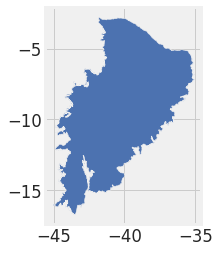

In [6]:
raster='/home/eduardo/projetos/conservacao_de_plantas_mudancas_climaticas/data/enviromental_data/landuse/mapbiomas/mapbiomas-none-2018.tif'
shp=gpd.read_file('/home/eduardo/projetos/conservacao_de_plantas_mudancas_climaticas/data/base_shapes/caatinga_ibge_2019_escala250m/caatinga_250m_2019.shp')
shp.plot()
shp=shp.geometry.unary_union

In [7]:
for e in glob('/home/eduardo/projetos/conservacao_de_plantas_mudancas_climaticas/data/species_ocurrence/processed/*'):
        ocorrencias=pd.read_csv(e,usecols=['specie','latitude', 'longitude'])
        specie=e.split('/')[-1].replace('.csv','').replace('_',' ')
        
        ocorrencias.specie=[specie]*ocorrencias.shape[0]
        
        ocorrencias = gpd.GeoDataFrame(ocorrencias,geometry=gpd.points_from_xy(x=ocorrencias.longitude,y=ocorrencias.latitude))        
        ocorrencias = ocorrencias[ocorrencias.geometry.intersects(shp)] 
        ocorrencias['lulc']= [rs.point_query(i,raster,interpolate='nearest')[0] for i in ocorrencias.geometry]

        ocorrencias=ocorrencias[pd.notnull(ocorrencias['lulc'])]
        ocorrencias=ocorrencias[ocorrencias.lulc!=24] #cidades
        ocorrencias=ocorrencias[ocorrencias.lulc!=33] #agua
        ocorrencias=ocorrencias[ocorrencias.lulc!=0] #sem dados
        ocorrencias=ocorrencias.drop(['lulc','geometry'],axis=1)
        ocorrencias.to_csv(e)
        

/home/eduardo/.local/lib/python3.6/site-packages/rasterstats/io.py:300: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


# Removendo Viés de Amostragem dos Dados de Ocorrência de Espécies

In [8]:
%%R
arq<-list.files('/home/eduardo/projetos/conservacao_de_plantas_mudancas_climaticas/data/species_ocurrence/processed/',pattern='.csv')
caatinga<-st_read("/home/eduardo/projetos/conservacao_de_plantas_mudancas_climaticas/data/base_shapes/caatinga_ibge_2019_escala250m/caatinga_250m_2019.shp")
caminhos<-paste('/home/eduardo/projetos/conservacao_de_plantas_mudancas_climaticas/data/species_ocurrence/processed/',arq,sep='')

Reading layer `caatinga_250m_2019' from data source `/home/eduardo/projetos/conservacao_de_plantas_mudancas_climaticas/data/base_shapes/caatinga_ibge_2019_escala250m/caatinga_250m_2019.shp' using driver `ESRI Shapefile'
Simple feature collection with 1 feature and 2 fields
geometry type:  POLYGON
dimension:      XY
bbox:           xmin: -45.07814 ymin: -16.71264 xmax: -35.06698 ymax: -2.748264
epsg (SRID):    NA
proj4string:    NA


In [9]:
%%R
for (i in 1:length(caminhos)){
    coordenadas <- read.table(caminhos[i],  header=TRUE,  sep=",")
    
    coordenadas <- subset(coordenadas, !is.na(coordenadas$longitude) & !is.na(coordenadas$latitude))
    coordinates(coordenadas) <- ~longitude+latitude
    grade <- raster(coordenadas)
    
    res(grade) <- 0.008333333
    
    grade <- extend(grade, extent(caatinga)+1)
    selecionados <- gridSample(coordenadas, grade, n=1)
    write.csv(selecionados,caminhos[i], row.names = TRUE)    
}

[1] "/home/eduardo/projetos/conservacao_de_plantas_mudancas_climaticas/data/species_ocurrence/processed/Amburana_cearensis.csv"
[1] "/home/eduardo/projetos/conservacao_de_plantas_mudancas_climaticas/data/species_ocurrence/processed/Anadenanthera_colubrina.csv"
[1] "/home/eduardo/projetos/conservacao_de_plantas_mudancas_climaticas/data/species_ocurrence/processed/Aspidosperma_multiflorum.csv"
[1] "/home/eduardo/projetos/conservacao_de_plantas_mudancas_climaticas/data/species_ocurrence/processed/Aspidosperma_pyrifolium.csv"
[1] "/home/eduardo/projetos/conservacao_de_plantas_mudancas_climaticas/data/species_ocurrence/processed/Bauhinia_cheilantha.csv"
[1] "/home/eduardo/projetos/conservacao_de_plantas_mudancas_climaticas/data/species_ocurrence/processed/Bauhinia_pentandra.csv"
[1] "/home/eduardo/projetos/conservacao_de_plantas_mudancas_climaticas/data/species_ocurrence/processed/Caesalpinia_bracteosa.csv"
[1] "/home/eduardo/projetos/conservacao_de_plantas_mudancas_climaticas/data/species_

# Formata Arquivo Final de Ocorrências

In [10]:
for arq in glob('/home/eduardo/projetos/conservacao_de_plantas_mudancas_climaticas/data/species_ocurrence/processed/*'):
    specie=arq.split('/')[-1].replace('.csv','').replace('_',' ')
    ocorrencias=pd.read_csv(arq, usecols=['longitude','latitude'])
    ocorrencias['specie']=[specie]*ocorrencias.shape[0]
    ocorrencias = ocorrencias.set_index('specie')
    fname=arq.replace('.csv','_'+str(ocorrencias.shape[0])+'.csv')
    ocorrencias.to_csv(fname) 
    os.remove(arq)
    

In [11]:
numero_ocorr=[int(arq.split('/')[-1].replace('.csv','').split('_')[-1]) for arq in glob('/home/eduardo/projetos/conservacao_de_plantas_mudancas_climaticas/data/species_ocurrence/processed/*')]    
planta=[' '.join(arq.split('/')[-1].replace('.csv','').split('_')[0:2]) for arq in glob('/home/eduardo/projetos/conservacao_de_plantas_mudancas_climaticas/data/species_ocurrence/processed/*')]    
planta=[e.split(' ')[0][0]+'. '+e.split(' ')[1] for e in planta]


# Recortando os dados do Soils Grids para os Limites da caatinga 


In [ ]:
%%R
files<-list.files('/home/eduardo/projetos/conservacao_de_plantas_mudancas_climaticas/data/enviromental_data/soil/world/250m/',pattern='.tif')
path<-paste('/home/eduardo/projetos/conservacao_de_plantas_mudancas_climaticas/data/enviromental_data/soil/world/250m/',files,sep='')

In [ ]:
%%R
#para cada raster de solo recorta e cria um novo com a extenção da camada caatinga
  for (i in 1:length(path)){
  fname<-paste('/home/eduardo/projetos/conservacao_de_plantas_mudancas_climaticas/data/enviromental_data/soil/caatinga/',files[i],sep='')
  raster_data<-raster(path[i])
  croped<-crop(raster_data,extent(caatinga))
  masked<-mask(croped,caatinga)
  writeRaster(masked, filename=fname, format="GTiff", overwrite=TRUE)
  }

In [ ]:
rename=[os.rename(e,e.replace('caatinga_','').replace('_M_','_').replace('_250m_ll','').replace('sl','')) for e in glob('/home/eduardo/projetos/conservacao_de_plantas_mudancas_climaticas/data/enviromental_data/soil/caatinga/*')]

In [ ]:
for i in glob('/home/eduardo/projetos/conservacao_de_plantas_mudancas_climaticas/data/enviromental_data/soil/caatinga/*'): 
    fname = i.replace('.tif','_teste.tif' ) 
    comando = 'gdal_translate -tr 0.008333333 0.008333333 {0} {1}'.format(i,fname) 
    os.system(comando) 
    os.rename(fname,i) 


# Verificando a Correlação das Camadas de Solo 

In [23]:
variaveis = [e.split('/')[-1][0:6].replace('_','') for e in glob('/home/eduardo/projetos/conservacao_de_plantas_mudancas_climaticas/data/enviromental_data/soil/caatinga/*') ]
variaveis = pd.unique(variaveis)
variaveis


array(['CRFVOL', 'SNDPPT', 'SLTPPT', 'CLYPPT', 'BLDFIE', 'BDRLOG',
       'BDRICM'], dtype=object)

In [24]:
%%R -i variaveis
#correlacao por variavel
for (i in 1:length(variaveis)){

  files<-list.files('/home/eduardo/projetos/conservacao_de_plantas_mudancas_climaticas/data/enviromental_data/soil/caatinga/',pattern=variaveis[i])
  path<-paste('/home/eduardo/projetos/conservacao_de_plantas_mudancas_climaticas/data/enviromental_data/soil/caatinga/',files,sep='')
  if (length(path)>2) {
      rasters<-stack(path)
      jnk=layerStats(rasters, 'pearson', na.rm=T)
      corr_matrix=jnk$'pearson correlation coefficient'


      png(paste(variaveis[i],".png",sep=''))
      corrplot(round(corr_matrix,3), method = "color",tl.col = "black",bg = "lightblue",addCoef.col = "black")
      dev.off()

      sr <- sampleRandom(rasters, 5000) # sample 5000 random grid cells
      autoplot(prcomp(sr),loadings.label = TRUE, data = sr,  loadings = TRUE)
      ggsave(paste('pca_',variaveis[i],".png",sep=''))
           
  }    
}

#|----------------------------------------------------------|
#|SNDPPT - areia %                                          |
#|CLYPPT - argila %                                         |
#|BLDFIE - fragmentos finos kg/m³                           |
#|SLTPPT - silte %                                          |
#|CRFVOL - fragmentos grossos volumetricos %                |
#|BDRICM - Profundidade Absoluta até a rocha matriz (em cm) |
#|BDRLOG - Probabilidade de Ocorrencia do Horizonte R       |
#|----------------------------------------------------------|

#AWCh1 - Capacidade disponível de água no solo (fração volumétrica) para h1
#AWCh2 - Capacidade disponível de água no solo (fração volumétrica) para h2
#AWCh3 - Capacidade disponível de água no solo (fração volumétrica) para h3

#AWCtS - Conteúdo Saturado de Água (Fração Volumétrica) para tS
#CECSOL - capacidade de troca cationica
#PHIHOX - pH em água

#-----------
#R = 0.7
#p = 0.05


R[write to console]: Saving 6.67 x 6.67 in image

R[write to console]: Saving 6.67 x 6.67 in image

R[write to console]: Saving 6.67 x 6.67 in image

R[write to console]: Saving 6.67 x 6.67 in image

R[write to console]: Saving 6.67 x 6.67 in image



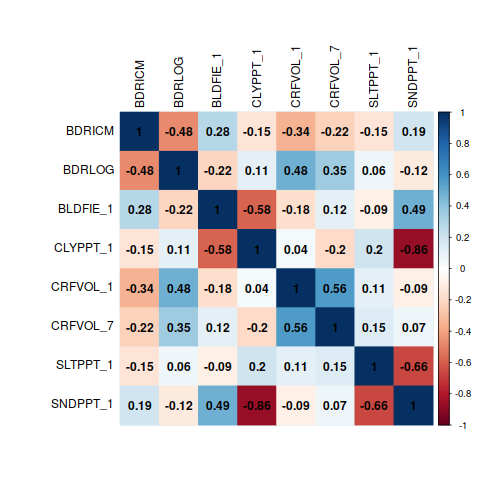

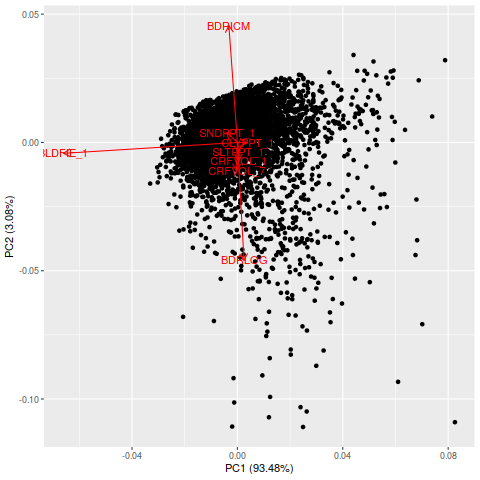

In [28]:
%%R 

#correlacao por variaveis escolhidas


files<-list.files('/home/eduardo/projetos/conservacao_de_plantas_mudancas_climaticas/data/enviromental_data/soil/selected/',pattern='')
path<-paste('/home/eduardo/projetos/conservacao_de_plantas_mudancas_climaticas/data/enviromental_data/soil/selected/',files,sep='')
rasters<-stack(path)
jnk=layerStats(rasters, 'pearson', na.rm=T)
corr_matrix=jnk$'pearson correlation coefficient' # se p maior que 0.05 há correlação
#png("ver-cor.png",width = 900, height = 900)
corrplot(round(corr_matrix,3), method = "color",tl.col = "black",bg = "lightblue",addCoef.col = "black")
#dev.off()
    
sr <- sampleRandom(rasters, 5000) # sample 5000 random grid cells
autoplot(prcomp(sr),loadings.label = TRUE, data = sr,  loadings = TRUE) 
#ggsave("pca_selecionados.png")
  


# Recortando os dados do CHELSEA para os Limites da caatinga 

In [10]:
%%R
files<-list.files('/home/eduardo/projetos/conservacao_de_plantas_mudancas_climaticas/data/enviromental_data/climate/current/world/chelsea/',pattern='.tif')
path<-paste('/home/eduardo/projetos/conservacao_de_plantas_mudancas_climaticas/data/enviromental_data/climate/current/world/chelsea/',files,sep='')

In [8]:
%%R
#para cada raster de solo recorta e cria um novo com a extenção da camada caatinga
  for (i in 1:length(path)){
  fname<-paste('/home/eduardo/projetos/conservacao_de_plantas_mudancas_climaticas/data/enviromental_data/climate/current/caatinga/',files[i],sep='')
  raster_data<-raster(path[i])
  croped<-crop(raster_data,extent(caatinga))
  masked<-mask(croped,caatinga)
  writeRaster(masked, filename=fname, format="GTiff", overwrite=TRUE)
  }

R[write to console]: Error in .local(x, y, ...) : Cannot get an Extent object from argument y
Calls: <Anonymous> ... <Anonymous> -> withVisible -> crop -> crop -> .local




Error in .local(x, y, ...) : Cannot get an Extent object from argument y
Calls: <Anonymous> ... <Anonymous> -> withVisible -> crop -> crop -> .local


# Verificando a Correlação das Camadas de Clima 

In [24]:
%%R 

files<-list.files('/home/eduardo/projetos/conservacao_de_plantas_mudancas_climaticas/data/enviromental_data/climate/current/caatinga/',pattern='CHELSA_bio10')
path<-paste('/home/eduardo/projetos/conservacao_de_plantas_mudancas_climaticas/data/enviromental_data/climate/current/caatinga/',files,sep='')
rasters<-stack(path)
jnk=layerStats(rasters, 'pearson', na.rm=T)
corr_matrix=jnk$'pearson correlation coefficient' # se p maior que 0.05 há correlação
png("clima.cor.png",width = 900, height = 900)
corrplot(round(corr_matrix,3), method = "color",tl.col = "black",bg = "lightblue",addCoef.col = "black")
dev.off()
    
sr <- sampleRandom(rasters, 5000) # sample 5000 random grid cells
autoplot(prcomp(sr),loadings.label = TRUE, data = sr,  loadings = TRUE) 
ggsave("pca_clima.png")


R[write to console]: Saving 6.67 x 6.67 in image



In [26]:
%%R 

files<-list.files('/home/eduardo/projetos/conservacao_de_plantas_mudancas_climaticas/data/enviromental_data/climate/current/selected/',pattern='.tif')
path<-paste('/home/eduardo/projetos/conservacao_de_plantas_mudancas_climaticas/data/enviromental_data/climate/current/selected/',files,sep='')
rasters<-stack(path)
jnk=layerStats(rasters, 'pearson', na.rm=T)
corr_matrix=jnk$'pearson correlation coefficient' # se p maior que 0.05 há correlação
png("climacor.png",width = 900, height = 900)
corrplot(round(corr_matrix,3), method = "color",tl.col = "black",bg = "lightblue",addCoef.col = "black")
dev.off()
    
sr <- sampleRandom(rasters, 5000) # sample 5000 random grid cells
autoplot(prcomp(sr),loadings.label = TRUE, data = sr,  loadings = TRUE) 
ggsave("pca.clima.png")


R[write to console]: Saving 6.67 x 6.67 in image



# Formatando as variáveis ambientais

In [52]:
%%R

f1<-list.files('/home/eduardo/projetos/conservacao_de_plantas_mudancas_climaticas/data/enviromental_data/climate/current/selected/',pattern='.tif')
f2<-list.files('/home/eduardo/projetos/conservacao_de_plantas_mudancas_climaticas/data/enviromental_data/soil/selected/',pattern='.tif')

p1<-paste('/home/eduardo/projetos/conservacao_de_plantas_mudancas_climaticas/data/enviromental_data/climate/current/selected/',f1,sep='')
p2<-paste('/home/eduardo/projetos/conservacao_de_plantas_mudancas_climaticas/data/enviromental_data/soil/selected/',f2,sep='')

p <-c(p1,p2)
f <-c(f1,f2)

novo_raster <- raster(nrow=1680, ncol=1200)
extent(novo_raster) <- extent(-45.07514,-35.06681,-16.70847,-2.750139)

 for (i in 1:length(p)){
     r <- raster(p[i])
     resol<- resample(r,novo_raster,method='bilinear')
     
     writeRaster(resol, filename=paste('/home/eduardo/projetos/conservacao_de_plantas_mudancas_climaticas/data/models/preditor/',f[i],sep=''),overwrite=TRUE, format="GTiff")
 }


# Verificando a Correlação das Camadas de Clima e Solo

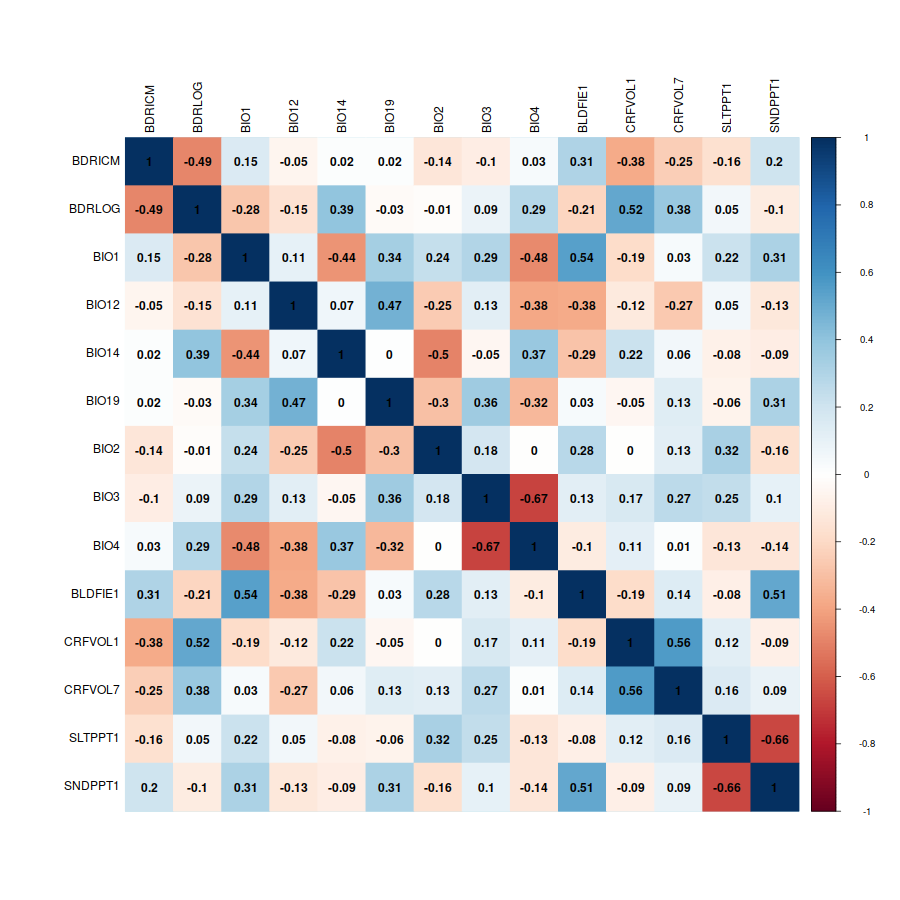

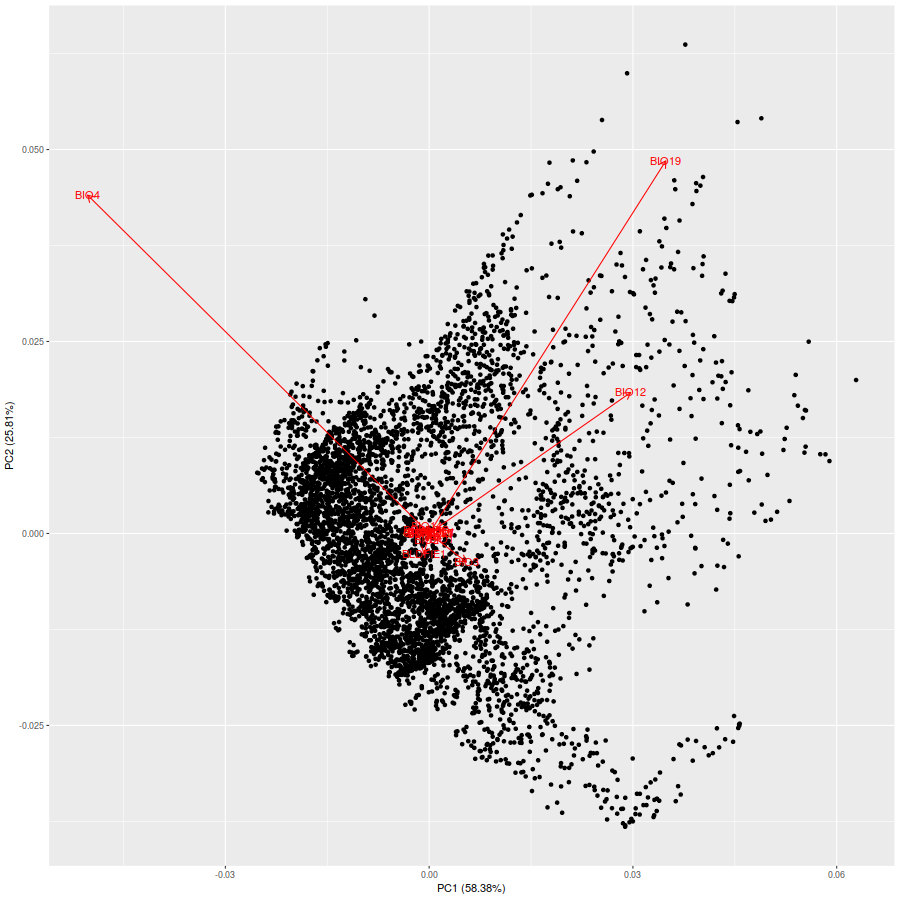

In [62]:
%%R -w 900 -h 900

files<-list.files('/home/eduardo/projetos/conservacao_de_plantas_mudancas_climaticas/data/models/preditor/',pattern='.tif')
path<-paste('/home/eduardo/projetos/conservacao_de_plantas_mudancas_climaticas/data/models/preditor/',files,sep='')


rasters<-stack(path)

jnk=layerStats(rasters, 'pearson', na.rm=T)
corr_matrix=jnk$'pearson correlation coefficient' # se p maior que 0.05 há correlação
#png("soil.climate.png",width = 900, height = 900)
corrplot(round(corr_matrix,3), method = "color",tl.col = "black",bg = "lightblue",addCoef.col = "black")
#dev.off()
    
sr <- sampleRandom(rasters, 5000) # sample 5000 random grid cells
autoplot(prcomp(sr),loadings.label = TRUE, data = sr,  loadings = TRUE) 
#ggsave("pca.soil.climate.png")